## Birds vs Forests

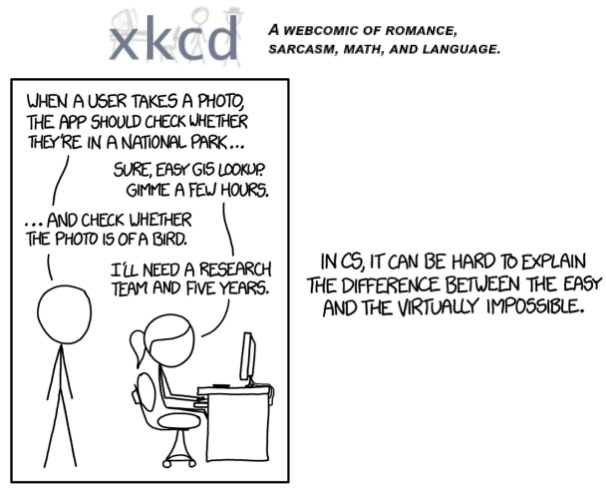

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
2. Use DuckDuckGo to search for images of "forest photos"
3. Fine-tune a pretrained neural network to recognise these two groups
4. Try running this model on a picture of a bird and see if it works.

### Step 1: Download images of birds and non-birds

In [1]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_results=10):
    print(f'Searching for {term}..')
    with DDGS() as ddgs:
        results = ddgs.images(term)
        return L([ next(results).get("image") for _ in range(max_results)])

bird_urls = search_images('bird photos')
bird_urls[0]

Searching for bird photos..


'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg'

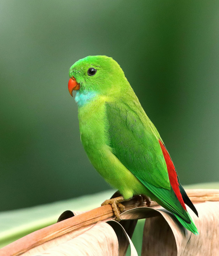

In [2]:
from fastdownload import download_url
from fastai.vision.all import *

filepath = 'bird.jpg'
download_url(bird_urls[0], filepath, show_progress=False)

img = Image.open(filepath)
img.to_thumb(256, 256)

And now the same for a forest:

Searching for forest photo..


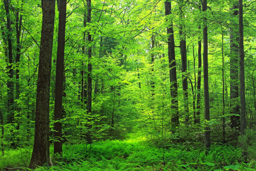

In [3]:
download_url(search_images('forest photo', max_results=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256, 256)

Let's download a bunch of these and store them in separate forlders:

In [4]:
from time import sleep

terms = ['bird', 'forest']
light_variations = ['', 'sunny', 'shade'] # use to search images with different lighting conditions 

for term in terms:
    base_path = Path('bird_or_not')/term
    base_path.mkdir(exist_ok=True, parents=True)

    for variation in light_variations:
        download_images(base_path, urls=search_images(f'{term} {variation} photo'))
        sleep(10)  # Pause between searches to avoid over-loading server

    print(f'Resizing {term} images..')    
    resize_images(base_path, max_size=400, dest=base_path)

# Verify images were downloaded correctly. Remove failed ones.
failed = verify_images(get_image_files('bird_or_not'))
failed.map(Path.unlink)
print(f'{len(failed)} images removed.')


Searching for bird  photo..
Searching for bird sunny photo..
Searching for bird shade photo..
Resizing bird images..
Searching for forest  photo..
Searching for forest sunny photo..
Searching for forest shade photo..
Resizing forest images..
2 images removed.


### Step 2: Train our model

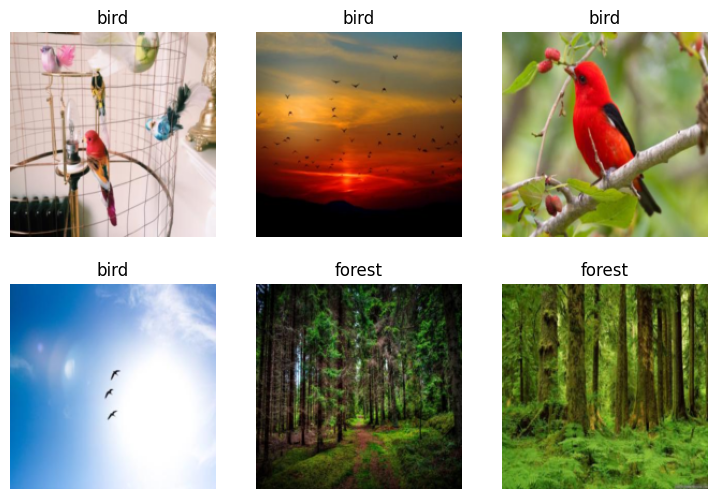

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(Path('bird_or_not'), bs=10)

dls.show_batch(max_n=6)

Let's fine tune the pretrained model `resnet18` with the photos we've just downloaded.

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.297164,0.445141,0.200000,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.686445,0.190437,0.100000,00:00
1,0.366781,0.032489,0.000000,00:00
2,0.255664,0.013083,0.000000,00:00


### Step 3: Use our fine-tuned model

In [11]:
for file in ['bird.jpg', 'forest.jpg']:
    
    image = PILImage.create(file)
    label, _, probs = learn.predict(image)

    print(f'{file} is a: {label} (probability: {probs[0]:.4f})')


bird.jpg is a: bird (probability: 0.9991)


forest.jpg is a: forest (probability: 0.0001)
